In [3]:
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE


def empirical_normal_res(X_obs: np.ndarray, N: int, random_seed: int = None):
    """
    Sequentially resample up to N points from empirical normal.
    Each new point is drawn from N(mean, cov) of all existing points (original + generated so far).
    Returns: stacked array of [X_obs, new_samples]
    """
    rng = np.random.default_rng(random_seed)
    X_gen = X_obs.copy()
    n, d = X_obs.shape
    n_to_generate = N - n
    new_samples = []
    for _ in range(n_to_generate):
        mean = X_gen.mean(axis=0)
        cov = np.cov(X_gen, rowvar=False)
        cov += 1e-6 * np.eye(d)
        sample = rng.multivariate_normal(mean, cov)
        new_samples.append(sample)
        X_gen = np.vstack([X_gen, sample])
    if new_samples:
        return np.vstack([X_obs, np.array(new_samples)])
    else:
        return X_obs.copy()


def oversample_resampling(X_obs, Y_obs, y, random_seed=None):
    mask = Y_obs == y
    X_majority = X_obs[~mask]
    Y_majority = Y_obs[~mask]
    N = np.sum(~mask)
    X_new = empirical_normal_res(X_obs[mask], N, random_seed)
    X_out = np.vstack([X_majority, X_new])
    Y_out = np.concatenate([Y_majority, np.full(N, y)])
    return X_out, Y_out


def undersample_random(X_obs, Y_obs, y, random_seed=None):
    rus = RandomUnderSampler(random_state=random_seed)
    X_out, Y_out = rus.fit_resample(X_obs, Y_obs)
    return X_out, Y_out


def oversample_random(X_obs, Y_obs, y, random_seed=None):
    ros = RandomOverSampler(random_state=random_seed)
    X_out, Y_out = ros.fit_resample(X_obs, Y_obs)
    return X_out, Y_out

def oversample_smote(X_obs, Y_obs, y, random_seed=None):
    smote = SMOTE(random_state=random_seed)
    X_out, Y_out = smote.fit_resample(X_obs, Y_obs)
    return X_out, Y_out

def no_resampling(X_obs, Y_obs, y, random_seed=None):
    """
    No resampling, just return the original data.
    """
    return X_obs.copy(), Y_obs.copy()

def test_oversample_resampling():
    n, m = 30, 4
    X_obs = np.random.randn(n, m)
    Y_obs = np.zeros(n, dtype=int)
    Y_obs[:10] = 1  # Minority class: 10 samples, Majority class: 20 samples
    np.random.shuffle(Y_obs)
    X_out, Y_out = oversample_resampling(X_obs, Y_obs, y=1)
    assert X_obs.shape == (n, m)
    assert X_out.shape[0] == 2 * np.sum(Y_obs == 0)
    assert X_out.shape[1] == m
    assert np.sum(Y_out == 0) == np.sum(Y_out == 1)
    X_out, Y_out = oversample_random(X_obs, Y_obs, y=1)
    assert X_obs.shape == (n, m)
    assert X_out.shape[0] == 2 * np.sum(Y_obs == 0)
    assert X_out.shape[1] == m
    assert np.sum(Y_out == 0) == np.sum(Y_out == 1)
    X_out, Y_out = oversample_smote(X_obs, Y_obs, y=1)
    assert X_obs.shape == (n, m)
    assert X_out.shape[0] == 2 * np.sum(Y_obs == 0)
    assert X_out.shape[1] == m
    assert np.sum(Y_out == 0) == np.sum(Y_out == 1)
    X_out, Y_out = undersample_random(X_obs, Y_obs, y=1)
    assert X_obs.shape == (n, m)
    assert X_out.shape[0] == 2 * np.sum(Y_obs == 1)
    assert X_out.shape[1] == m
    assert np.sum(Y_out == 0) == np.sum(Y_out == 1)
    print('Test passed.')

test_oversample_resampling()



Test passed.


In [12]:
# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def fit_predict_classifier(
        X_train,
        Y_train,
        X_test,
        clf,  # Classifier to use, e.g., RandomForestClassifier or LogisticRegression
        sampling_method=None,  # Function to use for resampling, e.g., oversample_resampling, undersample_random, or oversample_random
        y = 1,  # Class to oversample, only used if sampling_method is not None
        random_seed=None,
        B=1,  # Deep ensemble
):
    if sampling_method is not None:
        X_train, Y_train = sampling_method(X_train, Y_train, y, random_seed=random_seed)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    return Y_pred


def fit_predict_proba_classifier(
        X_train,
        Y_train,
        X_test,
        clf,  # Classifier to use, e.g., RandomForestClassifier or LogisticRegression
        sampling_method=None,  # Function to use for resampling, e.g., oversample_resampling, undersample_random, or oversample_random
        y = 1,  # Class to oversample, only used if sampling_method is not None
        random_seed=None,
        B=1,  # Number of bootstraps for Deep ensemble
):
    Y_proba_bootstraps = []
    seed = random_seed
    for i in range(B):
        # Updating random seed for each bootstrap
        if random_seed is not None:
            seed += 1
        
        # Resampling for class imbalance
        if sampling_method is not None:
            X_train, Y_train = sampling_method(X_train, Y_train, y, random_seed=seed)
        
        # Fitting the classifier
        clf.random_state = seed
        clf.fit(X_train, Y_train)

        # Extracting probabilities
        Y_proba = clf.predict_proba(X_test)  # Shape: (n_samples_test, n_classes)
        Y_proba_bootstraps.append(Y_proba)  # Shape: (B, n_samples_test, n_classes)
    
    # Averaging the probabilities across bootstraps
    Y_proba_avg = np.mean(Y_proba_bootstraps, axis=0)  # Shape: (n_samples_test, n_classes)

    return Y_proba_avg

def get_entropy(Y_proba):
    """
    Calculate the entropy of the predicted probabilities.
    :param Y_proba: Predicted probabilities of shape (n_samples, n_classes)
    :return: Entropy values for each sample
    """
    # Avoid log(0) by adding a small constant
    epsilon = 1e-10
    Y_proba = np.clip(Y_proba, epsilon, 1 - epsilon)
    return -np.sum(Y_proba * np.log(Y_proba), axis=1)  # Shape: (n_samples,)

def get_1_minus_sumsq(Y_proba):
    """
    Calculate 1 - sum of squares of predicted probabilities.
    :param Y_proba: Predicted probabilities of shape (n_samples, n_classes)
    :return: 1 - sum of squares for each sample
    """
    return 1 - np.sum(Y_proba ** 2, axis=1)  # Shape: (n_samples,)

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score, matthews_corrcoef, average_precision_score, roc_auc_score
from functools import partial
SCORES_MAP = {
    'accuracy': accuracy_score,
    'balanced_accuracy': balanced_accuracy_score,
    'f1': f1_score,
    'f1_1': partial(f1_score, pos_label=1),
    'f1_0': partial(f1_score, pos_label=0),
    'recall_1': partial(recall_score, pos_label=1),
    'recall_0': partial(recall_score, pos_label=0),
    'precision_1': partial(precision_score, pos_label=1),
    'precision_0': partial(precision_score, pos_label=0),
    'matthews_corrcoef': matthews_corrcoef,
    'average_precision': average_precision_score,
    'roc_auc': roc_auc_score
}
def get_scores(
        Y_pred,
        Y_true,
        scores_map: dict = SCORES_MAP,
):
    """
    Calculate various scores based on the predictions and true labels.
    :param Y_pred: Predicted labels or probabilities.  # If probabilities, will take the class with the highest probability.
    :param Y_true: True labels.
    :param scores_map: Dictionary mapping score names to scoring functions.
    :return: Dictionary of scores.
    """
    if Y_pred.ndim == 2 and Y_pred.shape[1] > 1:
        # If Y_pred is probabilities, take the class with the highest probability
        Y_pred = np.argmax(Y_pred, axis=1)
    return {name: score_func(Y_true, Y_pred)
            for name, score_func in scores_map.items() if hasattr(score_func, '__call__')}

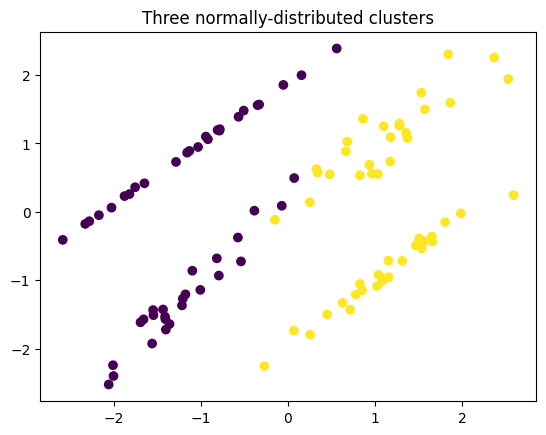

In [14]:
# DATASET: Diabetes dataset
import pandas as pd
from sklearn.datasets import load_diabetes, make_blobs, make_classification, make_blobs
diabetes = load_diabetes()
X = diabetes.data
feature_names = diabetes.feature_names
df = pd.DataFrame(X, columns=feature_names)
sex_idx = feature_names.index('sex')
# Make binary target: 1 for male (sex > 0), 0 for female (sex <= 0)
Y = (X[:, sex_idx] > 0).astype(int)
df["Y"] = Y
df = df.drop(columns="sex").dropna()
X = df.drop(columns="Y").values
Y = df["Y"].values


X, Y = make_classification(
    n_samples=100,
    n_classes=2,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    weights=[0.5, 0.5],  # Imbalanced dataset
    random_state=42,
    # return_X_y=True,
)


import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.title("Three normally-distributed clusters")
plt.show()

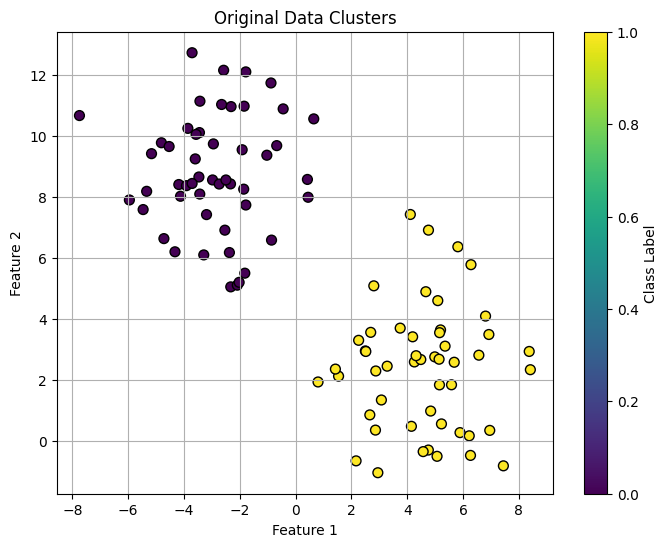

In [7]:
# scatterplot of clusters:
import matplotlib.pyplot as plt
def plot_clusters(X, Y, title="Clusters"):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Class Label')
    plt.grid()
    plt.show()
# Example usage of the plotting function
plot_clusters(X, Y, title="Original Data Clusters")


In [10]:
def train_with_few_ones(X, Y, one_ratio=0.1, random_state=None):
    """
    X_train: all zeros + 5% of the ones.
    X_test: remaining ones.

    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
    Y : np.ndarray, shape (n_samples,)
    one_ratio : float
        Proportion of ones to include in train.
    random_state : int or None
        Random seed.

    Returns
    -------
    X_train, X_test, Y_train, Y_test
    """
    rng = np.random.default_rng(random_state)
    ones_idx = np.where(Y == 1)[0]
    zeros_idx = np.where(Y == 0)[0]

    n_train_ones = int(one_ratio * len(ones_idx))
    n_train_zeros = len(ones_idx) - n_train_ones
    train_ones_idx = rng.choice(ones_idx, size=n_train_ones, replace=False)
    train_zeros_idx = rng.choice(zeros_idx, size=n_train_zeros, replace=False)
    
    train_idx = np.concatenate([train_zeros_idx, train_ones_idx])
    test_idx = np.setdiff1d(np.arange(len(Y)), train_idx)

    # Shuffle
    rng.shuffle(train_idx)
    rng.shuffle(test_idx)

    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_test = X[test_idx]
    Y_test = Y[test_idx]
    
    return X_train, X_test, Y_train, Y_test

In [ ]:
# DIABETES DATASET
from sklearn.datasets import load_diabetes, make_classification
from tqdm import tqdm
import pandas as pd

diabetes = load_diabetes()
X = diabetes.data
feature_names = diabetes.feature_names
df = pd.DataFrame(X, columns=feature_names)
sex_idx = feature_names.index('sex')
# Make binary target: 1 for male (sex > 0), 0 for female (sex <= 0)
Y = (X[:, sex_idx] > 0).astype(int)
df["Y"] = Y
df = df.drop(columns="sex").dropna()
X = df.drop(columns="Y").values
Y = df["Y"].values


# n_train = 500
# n_test = 500
ones_ratio = 0.1

sampling_methods = {
    "oversample_resampling": oversample_resampling,
    "oversample_random": oversample_random,
    "oversample_smote": oversample_smote,
    "undersample_random": undersample_random,
    "no_resampling": no_resampling,
}
avg_scores = None
iter = 25
B = 10


for i in tqdm(range(iter)):
    X_obs, X_test, Y_obs, Y_test = train_with_few_ones(X, Y, one_ratio=ones_ratio, random_state=421+i)

    scores_dict = {}
    for name, sampling_method in sampling_methods.items():
        Y_probas = fit_predict_proba_classifier(
            X_obs, Y_obs, X_test,
            clf=RandomForestClassifier(),
            sampling_method=sampling_method,
            random_seed=412+i,
            y=1,
            B=B,  # Number of bootstraps for Deep ensemble
        )
        Y_pred = np.argmax(Y_probas, axis=1)
        method_scores_dict = get_scores(Y_pred, Y_test)
        scores_dict[name] = method_scores_dict
    # Average scores across iterations
    if avg_scores is None:
        avg_scores = pd.DataFrame(scores_dict)
    else:
        avg_scores += pd.DataFrame(scores_dict)
avg_scores /= iter
# print_scores_table(scores_dict)
print("DATASET: Diabetes dataset")
print("Average scores across iterations:")
display(avg_scores)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [04:49<00:00, 11.57s/it]


DATASET: Diabetes dataset
Average scores across iterations:


,oversample_resampling,oversample_random,oversample_smote,undersample_random,no_resampling
accuracy,0.451064,0.298553,0.372085,0.641021,0.240170
balanced_accuracy,0.594376,0.546863,0.574483,0.637854,0.517921
f1,0.501382,0.220799,0.368782,0.737434,0.090819
f1_1,0.501382,0.220799,0.368782,0.737434,0.090819
f1_0,0.384771,0.360430,0.373840,0.417826,0.346872
recall_1,0.352086,0.127059,0.232299,0.643209,0.048342
recall_0,0.836667,0.966667,0.916667,0.632500,0.987500
precision_1,0.892099,0.935064,0.915080,0.873941,0.934751
precision_0,0.250235,0.221586,0.234885,0.317093,0.210404
matthews_corrcoef,0.163694,0.119887,0.149178,0.229273,0.068928


In [29]:
# WINE DATASET
from sklearn.datasets import load_wine
from tqdm import tqdm
import pandas as pd

wine = load_wine()

X = wine.data
Y = wine.target

# keep only two classes: 0 and 1
mask = Y != 2
X = X[mask]
Y = Y[mask]


# n_train = 500
# n_test = 500
ones_ratio = 0.25

sampling_methods = {
    "oversample_resampling": oversample_resampling,
    "oversample_random": oversample_random,
    "oversample_smote": oversample_smote,
    "undersample_random": undersample_random,
    "no_resampling": no_resampling,
}
avg_scores = None
iter = 25
B = 10


for i in tqdm(range(iter)):
    X_obs, X_test, Y_obs, Y_test = train_with_few_ones(X, Y, one_ratio=ones_ratio, random_state=421+i)

    scores_dict = {}
    for name, sampling_method in sampling_methods.items():
        Y_probas = fit_predict_proba_classifier(
            X_obs, Y_obs, X_test,
            clf=RandomForestClassifier(),
            sampling_method=sampling_method,
            random_seed=412+i,
            y=1,
            B=B,  # Number of bootstraps for Deep ensemble
        )
        Y_pred = np.argmax(Y_probas, axis=1)
        method_scores_dict = get_scores(Y_pred, Y_test)
        scores_dict[name] = method_scores_dict
    # Average scores across iterations
    if avg_scores is None:
        avg_scores = pd.DataFrame(scores_dict)
    else:
        avg_scores += pd.DataFrame(scores_dict)
avg_scores /= iter
# print_scores_table(scores_dict)
print("DATASET: Diabetes dataset")
print("Average scores across iterations:")
display(avg_scores)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [02:45<00:00,  6.63s/it]

DATASET: Diabetes dataset
Average scores across iterations:


,oversample_resampling,oversample_random,oversample_smote,undersample_random,no_resampling
accuracy,0.970847,0.960678,0.961356,0.978305,0.958644
balanced_accuracy,0.984074,0.978519,0.978889,0.984519,0.977407
f1,0.983576,0.977691,0.977941,0.987930,0.976624
f1_1,0.983576,0.977691,0.977941,0.987930,0.976624
f1_0,0.866973,0.830253,0.836455,0.891866,0.817632
recall_1,0.968148,0.957037,0.957778,0.977037,0.954815
recall_0,1.000000,1.000000,1.000000,0.992000,1.000000
precision_1,1.000000,1.000000,1.000000,0.999273,1.000000
precision_0,0.778413,0.726760,0.736753,0.820556,0.704380
matthews_corrcoef,0.864982,0.829729,0.835732,0.888842,0.816755


In [ ]:

# RANDOM DATA GENERATION
from tqdm import tqdm
# n_train = 500
# n_test = 500
ones_ratio = 0.1

sampling_methods = {
    "oversample_resampling": oversample_resampling,
    "oversample_random": oversample_random,
    "oversample_smote": oversample_smote,
    "undersample_random": undersample_random,
    "no_resampling": no_resampling,
}
avg_scores = None
iter = 25
B = 10


for i in tqdm(range(iter)):
    X, Y = make_classification(
        n_samples=1000,
        n_classes=2,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        weights=[0.5, 0.5],  # Imbalanced dataset
        random_state=421+i
    )
    # X, Y = make_blobs(centers=2, n_samples=1000, random_state=421+i, cluster_std=2)
    X_obs, X_test, Y_obs, Y_test = train_with_few_ones(X, Y, one_ratio=ones_ratio, random_state=421+i)

    scores_dict = {}
    for name, sampling_method in sampling_methods.items():
        Y_probas = fit_predict_proba_classifier(
            X_obs, Y_obs, X_test,
            clf=RandomForestClassifier(),
            sampling_method=sampling_method,
            random_seed=412+i,
            y=1,
            B=B,  # Number of bootstraps for Deep ensemble
        )
        Y_pred = np.argmax(Y_probas, axis=1)
        method_scores_dict = get_scores(Y_pred, Y_test)
        scores_dict[name] = method_scores_dict
    # Average scores across iterations
    if avg_scores is None:
        avg_scores = pd.DataFrame(scores_dict)
    else:
        avg_scores += pd.DataFrame(scores_dict)
avg_scores /= iter
print("DATASET: Randomly generated data")
display(avg_scores)

100%|██████████| 5/5 [00:50<00:00, 10.07s/it]


,oversample_resampling,oversample_random,oversample_smote,undersample_random,no_resampling
accuracy,0.826167,0.615807,0.733181,0.790554,0.539928
balanced_accuracy,0.861746,0.777445,0.837706,0.835015,0.743931
f1,0.893433,0.724257,0.825230,0.869395,0.646624
f1_1,0.893433,0.724257,0.825230,0.869395,0.646624
f1_0,0.520917,0.346105,0.426585,0.466921,0.312443
recall_1,0.817383,0.574559,0.706629,0.779650,0.487862
recall_0,0.906109,0.980331,0.968784,0.890379,1.000000
precision_1,0.987203,0.996179,0.995136,0.984357,1.000000
precision_0,0.370661,0.210905,0.274308,0.319203,0.185936
matthews_corrcoef,0.507272,0.338944,0.426480,0.450129,0.300832


In [13]:
from numpy import mean


X = np.array([
    [0,1],
    [0,2],
    [0, 1.5],
    [0, 4],
    [1, 0],
    [1, 1],
    [1, 2],
    [1, 3],
    [1, 4],
])

Y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])

X_test = np.array([
    [0, 1],
    [0, 2],
    [0, 3],
    [1, 0],
    [1, 1],
    [1, 2],
])

B = 2
Y_proba_bootstraps = []
for i in range(B):
    clf = RandomForestClassifier(n_estimators=10)

    clf.random_state = 42 + i
    clf.fit(X, Y)
    Y_proba = clf.predict_proba(X_test)
    Y_proba_bootstraps.append(Y_proba)

Y_proba_bootstraps = np.array(Y_proba_bootstraps)
mean_Y_proba = mean(Y_proba_bootstraps, axis=0)
uncertainty = np.std(Y_proba_bootstraps, axis=0)
entropy = -np.sum(mean_Y_proba * np.log(mean_Y_proba + 1e-10), axis=1)
one_minus_sumsq = 1 - np.sum(mean_Y_proba**2, axis=1)  # shape (n_test,)

print("Bootstrapped probabilities:", Y_proba_bootstraps)
# print("Mean probabilities:", mean_Y_proba)
# print("Uncertainty (std dev):", uncertainty)
# print("Entropy:", entropy)
# print("One minus sum of squares:", one_minus_sumsq)


Bootstrapped probabilities: [[[0.8 0.2]
  [0.8 0.2]
  [0.7 0.3]
  [0.  1. ]
  [0.  1. ]
  [0.  1. ]]

 [[0.8 0.2]
  [0.9 0.1]
  [0.5 0.5]
  [0.2 0.8]
  [0.2 0.8]
  [0.  1. ]]]


In [76]:
# Scores
def get_scores_for_samplers(
    X_train, Y_train, X_test, Y_test,
    clf, sampling_methods, random_seed=None, y=1
):
    from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score, matthews_corrcoef, average_precision_score, roc_auc_score

    scores_dict = {}
    for name, sampler in sampling_methods.items():
        clf_ = clf.__class__(**clf.get_params())
        Y_pred = fit_predict_classifier(X_train, Y_train, X_test, clf_, sampler, y, random_seed)
        scores = {
            "accuracy": accuracy_score(Y_test, Y_pred),
            "balanced_accuracy": balanced_accuracy_score(Y_test, Y_pred),
            "f1": f1_score(Y_test, Y_pred),
            "precision": precision_score(Y_test, Y_pred),
            "recall": recall_score(Y_test, Y_pred),
            "mcc": matthews_corrcoef(Y_test, Y_pred),
            "avg_precision": average_precision_score(Y_test, Y_pred)
        }
        try:
            scores["roc_auc"] = roc_auc_score(Y_test, Y_pred)
        except Exception:
            scores["roc_auc"] = None
        scores_dict[name] = scores
    return scores_dict


def print_scores_table(scores_dict):
    import pandas as pd
    df = pd.DataFrame(scores_dict)
    display(df)


In [88]:
import numpy as np
from scipy.stats import chi2

def make_ball_outlier_dataset(n_samples, mean, cov, ones_ratio=0.15):
    """
    Generate a binary classification dataset: X from N(mean, cov), 
    Y = 1 if X is outside a ball containing 95% of the probability mass, else 0.

    Parameters
    ----------
    n_samples : int
        Number of samples.
    mean : array_like
        Mean vector of the distribution.
    cov : array_like
        Covariance matrix.
    
    Returns
    -------
    X : ndarray, shape (n_samples, n_features)
        The data matrix.
    Y : ndarray, shape (n_samples,)
        Binary target vector: 1 for outside the ball, 0 for inside.
    """
    mean = np.asarray(mean)
    X = np.random.multivariate_normal(mean, cov, size=n_samples)
    n_features = X.shape[1]
    
    # Squared Mahalanobis distance from the mean
    d2 = np.sum((X - mean) @ np.linalg.inv(cov) * (X - mean), axis=1)
    # Find radius squared so that 95% are inside (so 5% get label 1)
    r2 = chi2.ppf(1-ones_ratio, df=n_features)
    Y = (d2 > r2).astype(int)
    return X, Y



In [77]:
import pandas as pd
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X = diabetes.data
feature_names = diabetes.feature_names
df = pd.DataFrame(X, columns=feature_names)
sex_idx = feature_names.index('sex')
# Make binary target: 1 for male (sex > 0), 0 for female (sex <= 0)
Y = (X[:, sex_idx] > 0).astype(int)
df["Y"] = Y
df = df.drop(columns="sex").dropna()
X = df.drop(columns="Y").values
Y = df["Y"].values

In [ ]:
from numpy import ones


n_train = 500
n_test = 500
ones_ratio = 0.2
# X, Y = make_ball_outlier_dataset(n_train+n_test, mean=np.zeros(4), cov=np.array([[1, 0.2, 0.1, 0.3],
#                                                                                   [0.2, 3, 0.5, 0.6],
#                                                                                   [0.1, 0.5, 2, 0.5],
#                                                                                   [0.3, 0.6, 0.5, 1]]), ones_ratio=ones_ratio)
sampling_methods = {
    "oversample_resampling": oversample_resampling,
    "oversample_random": oversample_random,
    "oversample_smote": oversample_smote,
    "undersample_random": undersample_random,
    "no_resampling": no_resampling,
}
avg_scores = None
iter = 50
from tqdm import tqdm
for i in tqdm(range(iter)):
    X_obs, X_test, Y_obs, Y_test = train_with_few_ones(X, Y, one_ratio=ones_ratio, random_state=421+i)

    scores_dict = get_scores_for_samplers(
        X_obs, Y_obs, X_test, Y_test,
        RandomForestClassifier(random_state=421+i),
        sampling_methods,
        random_seed=412+i,
        y=1
    )
    if avg_scores is None:
        avg_scores = pd.DataFrame(scores_dict)
    else:
        avg_scores += pd.DataFrame(scores_dict)
avg_scores /= iter
# print_scores_table(scores_dict)
display(avg_scores)

100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


,oversample_resampling,oversample_random,oversample_smote,undersample_random,no_resampling
accuracy,0.786916,0.851011,0.837278,0.792235,0.868315
balanced_accuracy,0.802049,0.733243,0.772078,0.787832,0.732986
f1,0.608984,0.588274,0.619204,0.601592,0.603923
precision,0.483958,0.661496,0.584944,0.491994,0.763469
recall,0.827250,0.537125,0.663500,0.780500,0.507625
mcc,0.510607,0.505813,0.520141,0.496077,0.548348
avg_precision,0.434770,0.446493,0.454852,0.428023,0.483943
roc_auc,0.802049,0.733243,0.772078,0.787832,0.732986
